In [1]:
import scanpy as sc
import singleCellHaystack as hs

sc.set_figure_params(facecolor="white", dpi=90)

# Load data

We load the human PBMC data available from scanpy.

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/diez/miniconda3/envs/singleCellHaystack/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


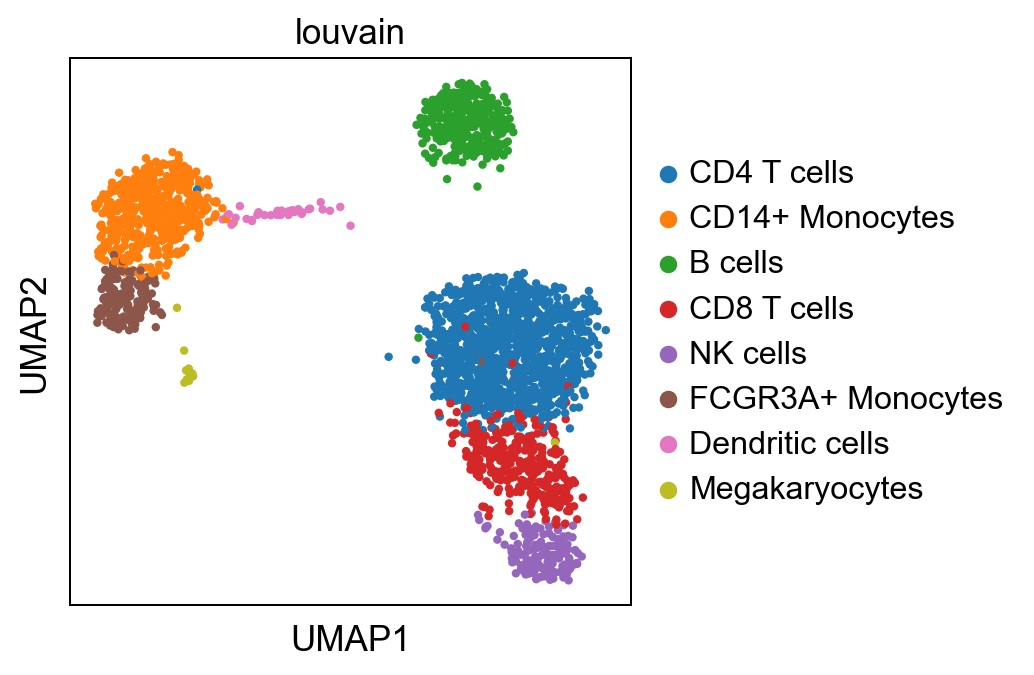

In [3]:
sc.pl.umap(adata, color="louvain")

# Filter some cells

We remove Megakaryocytes since they are not interesting in this example and they will drive the top results.

In [4]:
mega = adata.obs.louvain.isin(["Megakaryocytes"])
mega.value_counts()

False    2623
True       15
Name: louvain, dtype: int64

In [5]:
adata = adata[~mega, :]
adata

View of AnnData object with n_obs × n_vars = 2623 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Run haystack

We run `haystack` using PCA coordinates and otherwise default parameters. Since the data has been scaled, we need to pass the raw data to avoid negative numbers. Also this will allow `haystack` to run on all the genes, not only those to calculate the PCA coordinates.

In [6]:
res = hs.haystack(adata.raw.to_adata(), coord="pca")

> starting haystack ...
> entering array method ...
> scaling coordinates ...
> calculating feature stds ...
> removing 6 genes with zero variance ...
> calculating grid points ...
> calculating distance to cells ...
> calculating densities ...
> calculating Q dist ...
> calculating KLD for 13708 features ...


100%|██████████| 13708/13708 [00:02<00:00, 5908.38it/s]


> calculating feature's CV ...
> selecting genes to randomize ...
> calculating randomized KLD ...


100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


> calculating P values ...
> done.


# Check some QC plots

We can examine some of the QC plots. First the randomization fits. These are used to calculate KLD from randomized expression levels for a subset of genes, in order to estimate the values to the entire gene set.

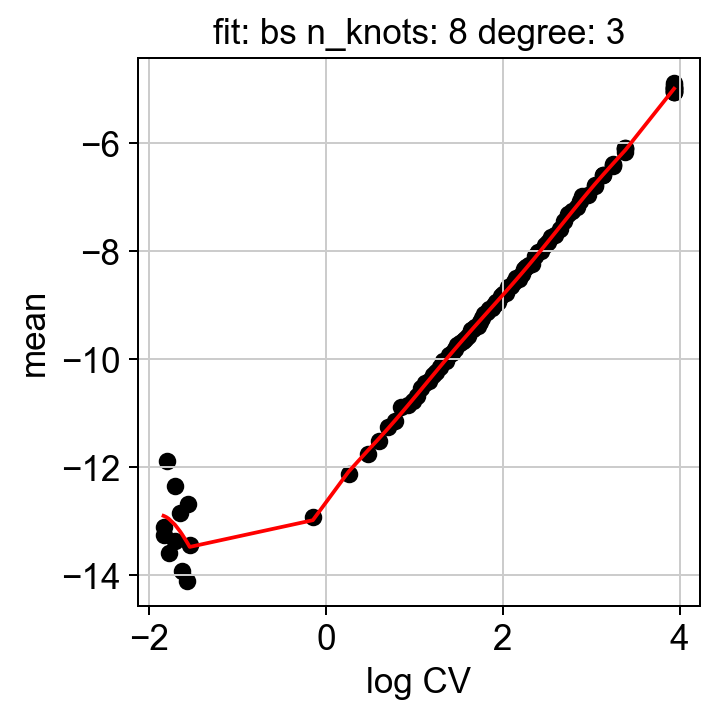

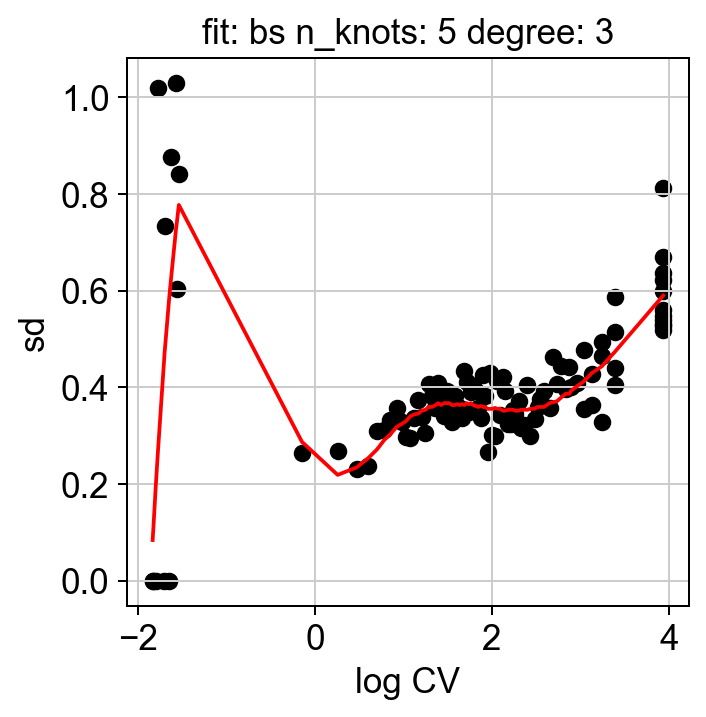

In [7]:
hs.plot_rand_fit(res, "mean")
hs.plot_rand_fit(res, "sd")

The ranking of logpval and distribution of pval gives us some idea of how many significant genes we can detect.

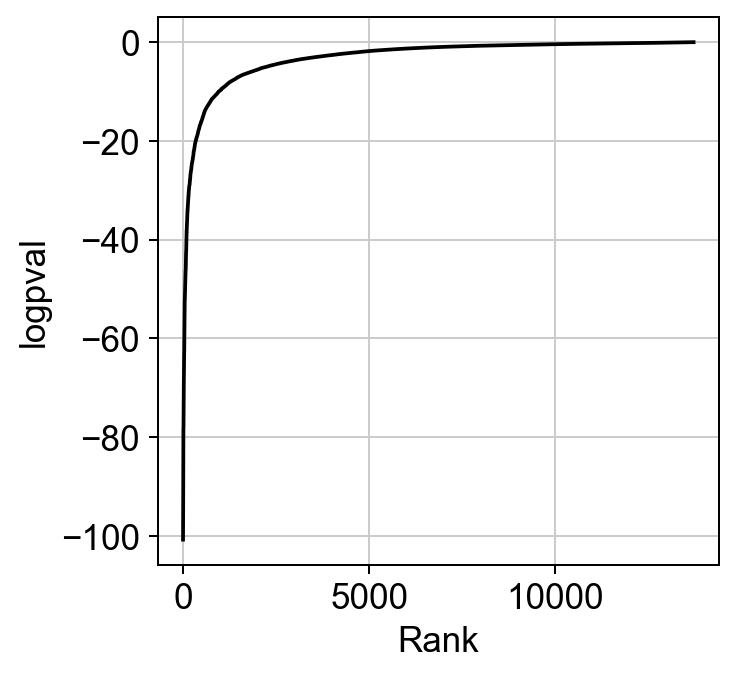

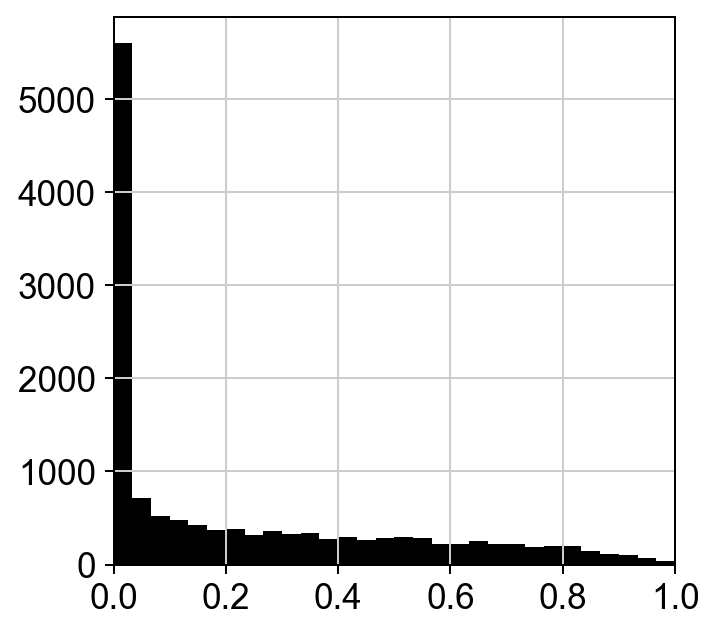

In [8]:
hs.plot_pval_rank(res)
hs.plot_pval_hist(res)

# Visualizing the results

A pandas DataFrame with the results can be obtained. By default the results are sorted by logpval_adj.

In [9]:
sum = res["results"]
sum

,gene,KLD,pval,pval_adj,logpval,logpval_adj
4407,HLA-DRA,0.000543,1.771420e-101,2.428262e-97,-100.751679,-96.614704
4409,HLA-DRB1,0.000582,1.987686e-100,2.724720e-96,-99.701652,-95.564678
4427,HLA-DPB1,0.000481,5.362385e-98,7.350757e-94,-97.270642,-93.133668
4426,HLA-DPA1,0.000514,7.977697e-96,1.093583e-91,-95.098122,-90.961148
12667,TYROBP,0.000658,1.187506e-94,1.627833e-90,-93.925364,-89.788390
...,...,...,...,...,...,...
10827,AC040977.1,0.000111,9.910935e-01,1.000000e+00,-0.003885,0.000000
7620,LIN7C,0.000048,9.936107e-01,1.000000e+00,-0.002784,0.000000
7085,AGAP4,0.000325,9.979420e-01,1.000000e+00,-0.000895,0.000000
6992,CDNF,0.000317,9.983121e-01,1.000000e+00,-0.000734,0.000000


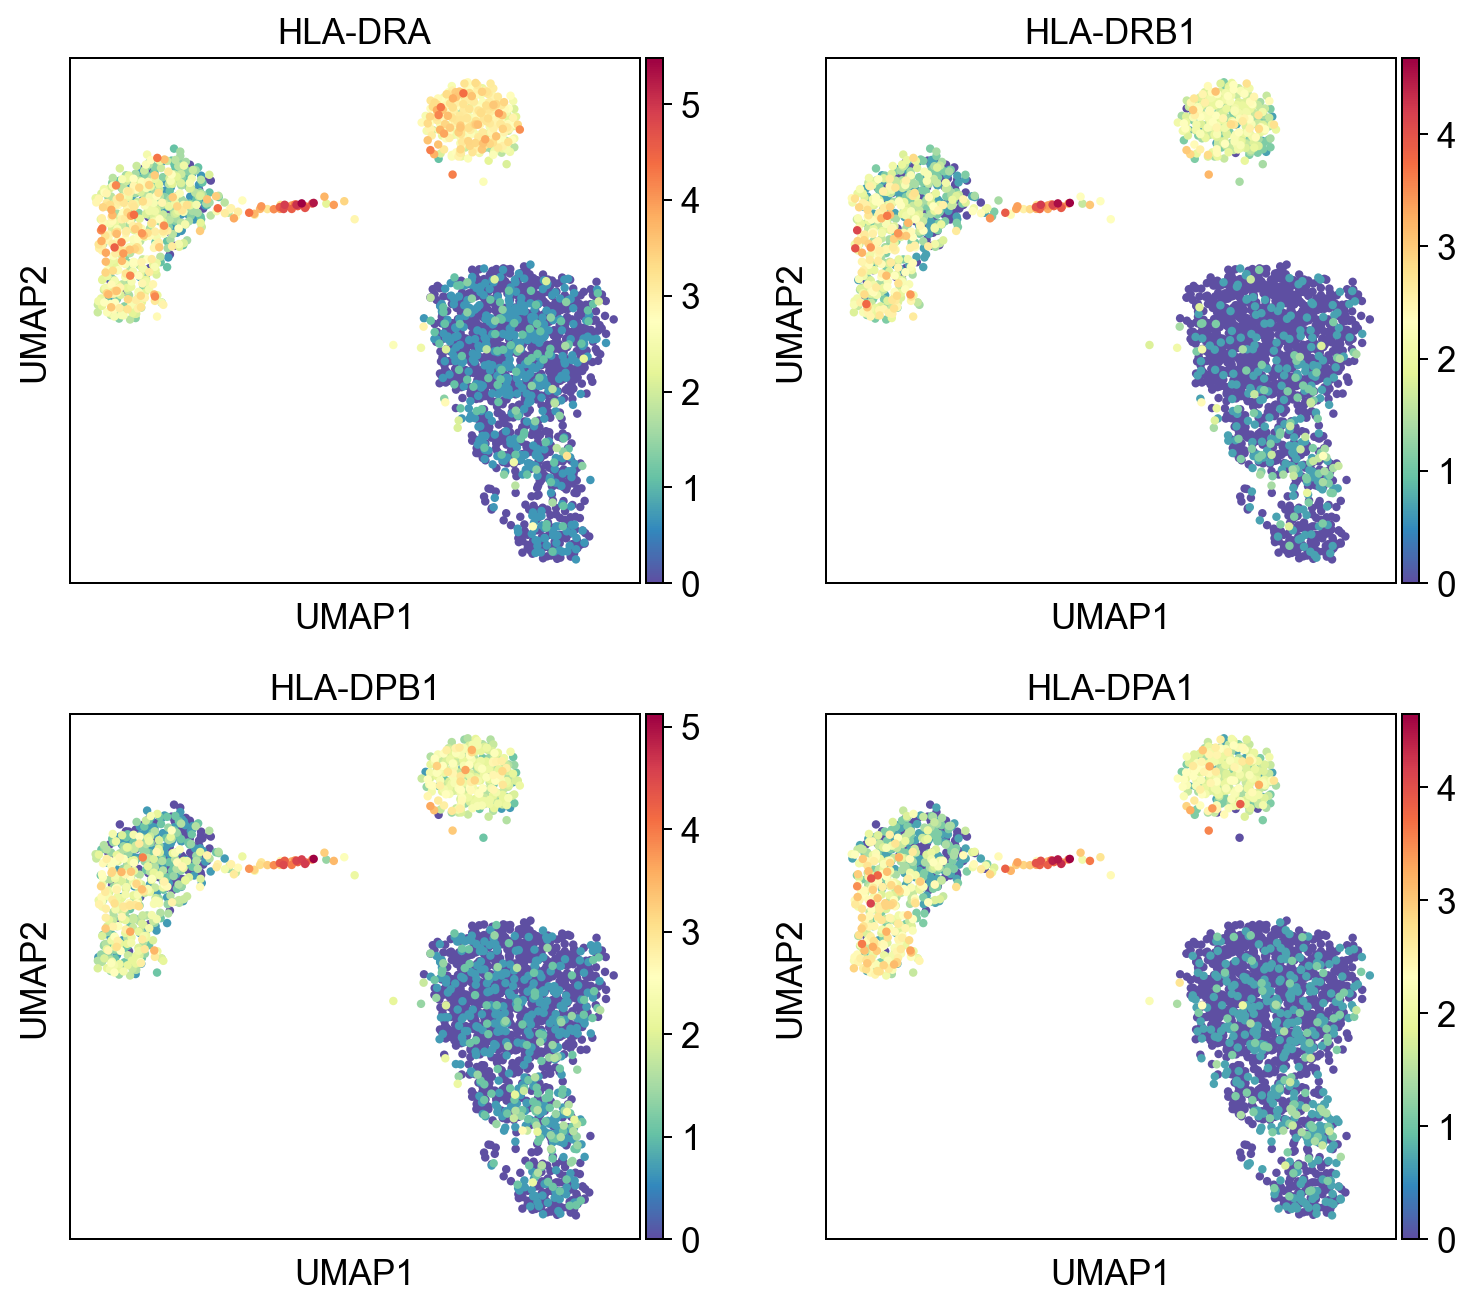

In [10]:
sc.pl.umap(adata, color=sum.gene.iloc[:4], ncols=2, cmap="Spectral_r")

# Clustering results into gene modules

We can cluster the results using K-means. We need to pass the `AnnData` object, the haystack results and the number of clusters.

In [11]:
gene_mods = hs.cluster_genes(adata.raw.to_adata(), res, n_clusters=4)
gene_mods.sort_values("cluster").groupby("cluster").head(3)

,gene,cluster
49,CFD,0
40,SRGN,0
41,LGALS2,0
95,GIMAP4,1
36,CD7,1
37,LCK,1
35,HLA-DMA,2
2,HLA-DPB1,2
1,HLA-DRB1,2
86,FGFBP2,3


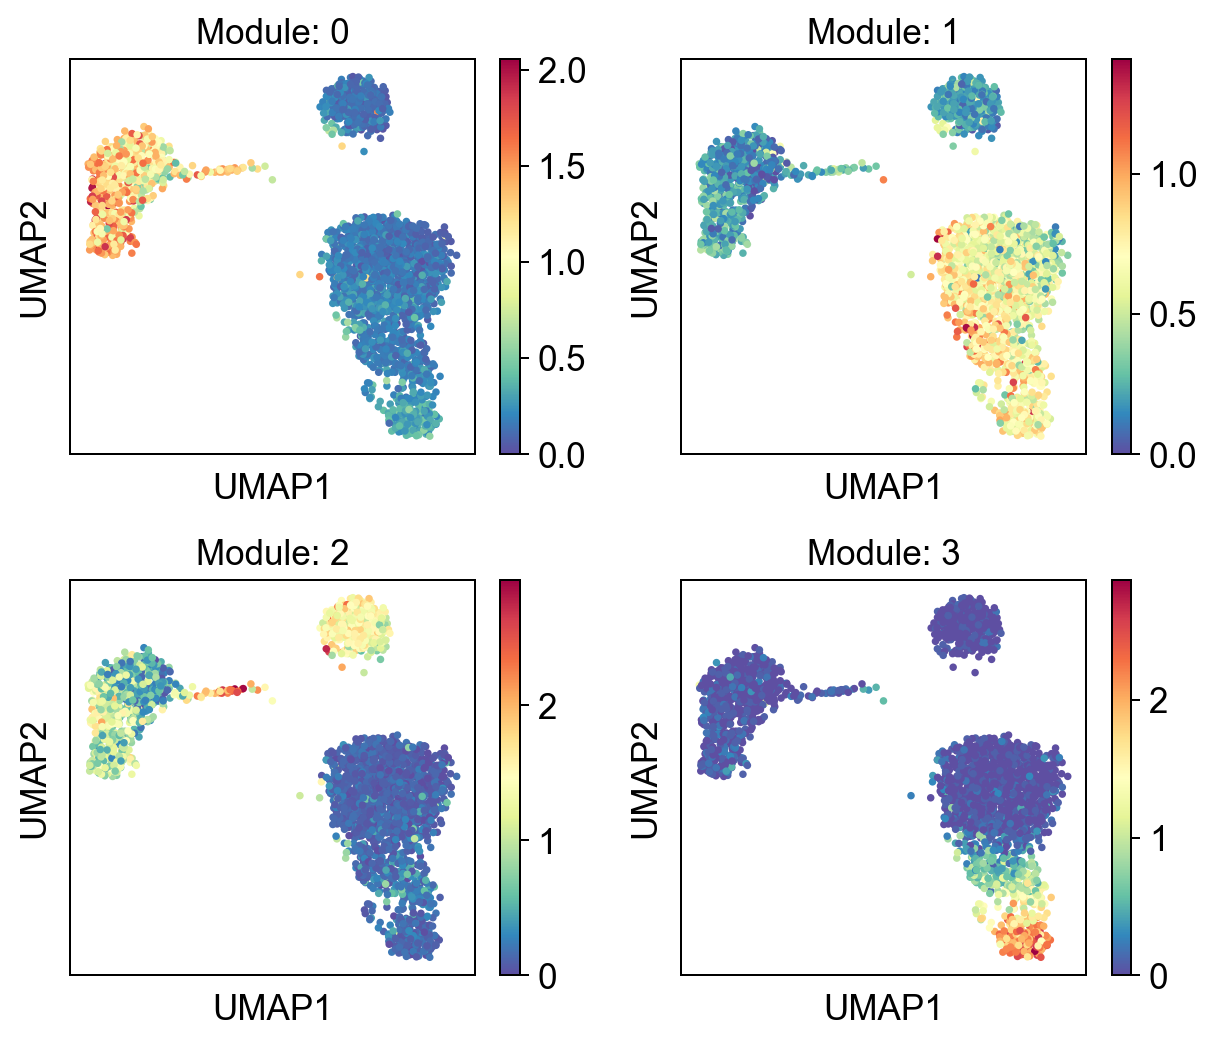

In [12]:
hs.plot_gene_clusters(adata.raw.to_adata(), gene_mods, basis="umap", ncols=2, figsize=[7, 6],   color_map="Spectral_r")

In [13]:
mod0 = gene_mods.groupby("cluster").get_group(1)
mod0.head(4)

,gene,cluster
9,CD3D,1
10,IL32,1
19,CD3E,1
27,CTSW,1


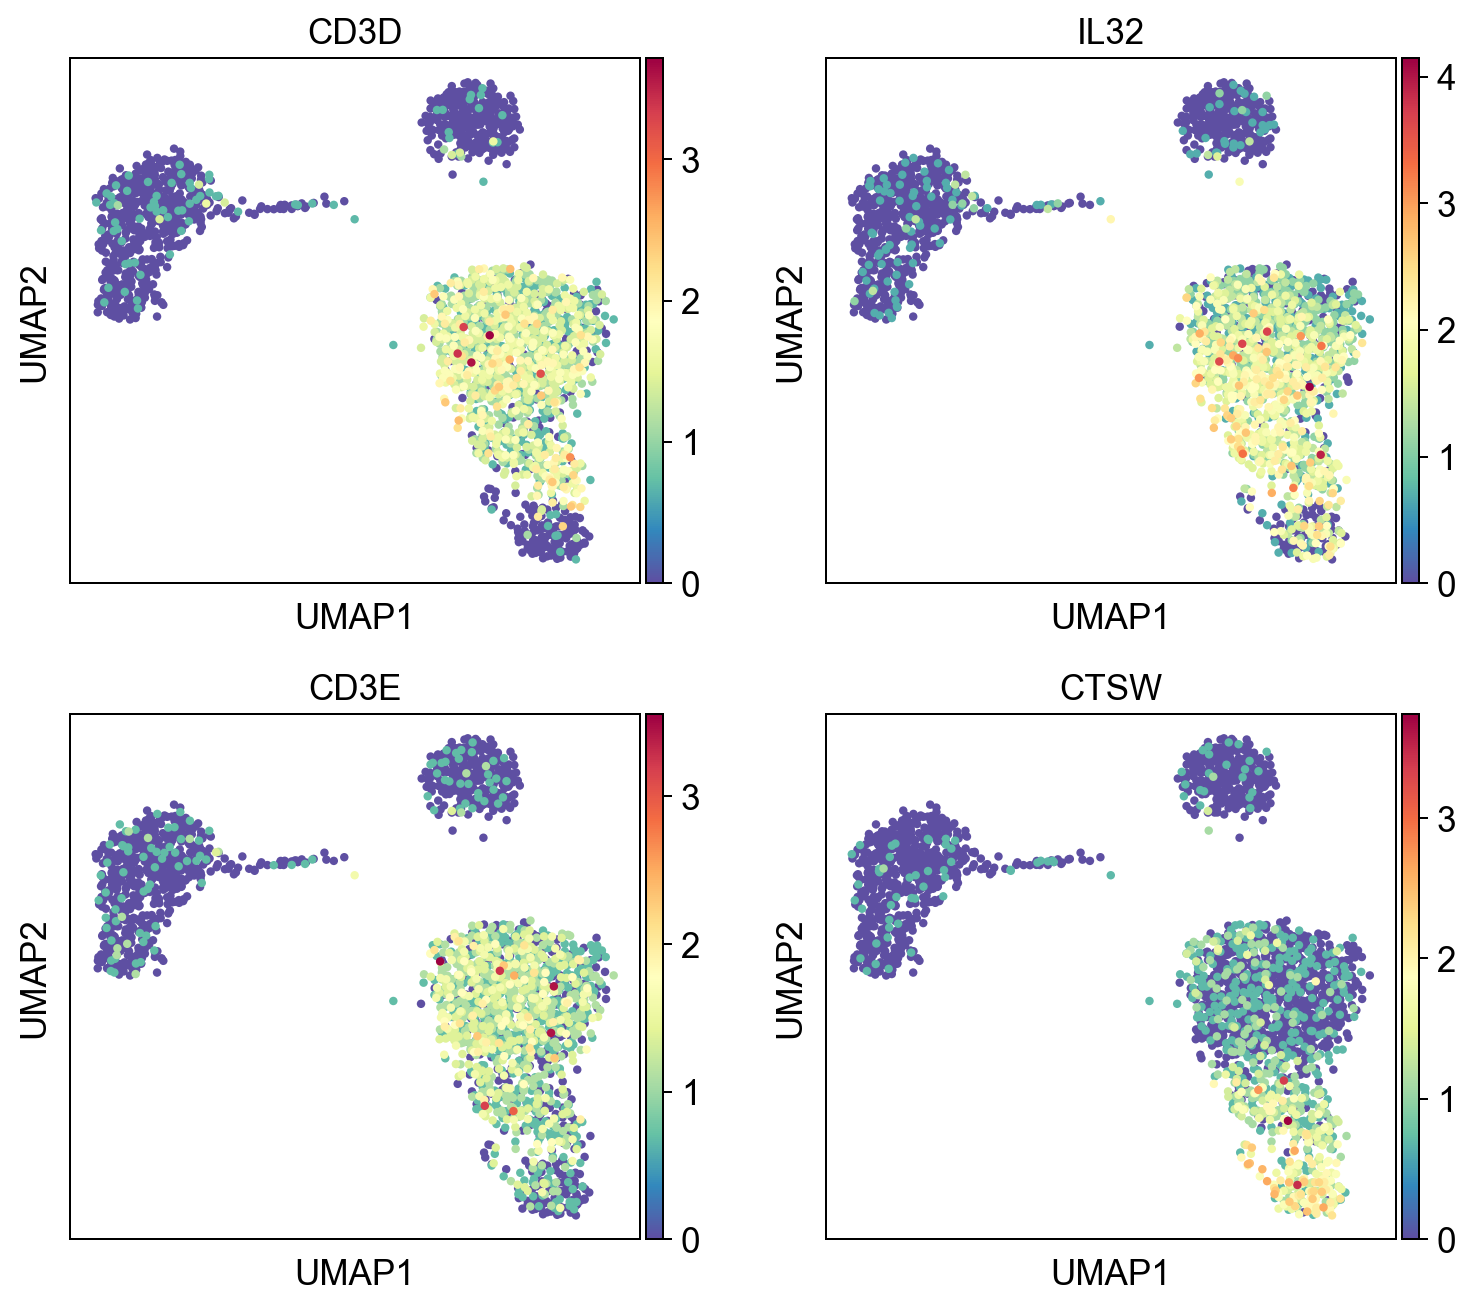

In [14]:
sc.pl.umap(adata, color=mod0.gene.iloc[:4], cmap="Spectral_r", ncols=2)

# Export results

In [15]:
#sum.to_csv("pbmc3k-results.tsv")